<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/PCA_%D0%B4%D0%BB%D1%8F_Kelly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=99bdaa1aca0c5acf7b76a4b629b3d7c38f761398acf58c0c976cd5707c880296
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


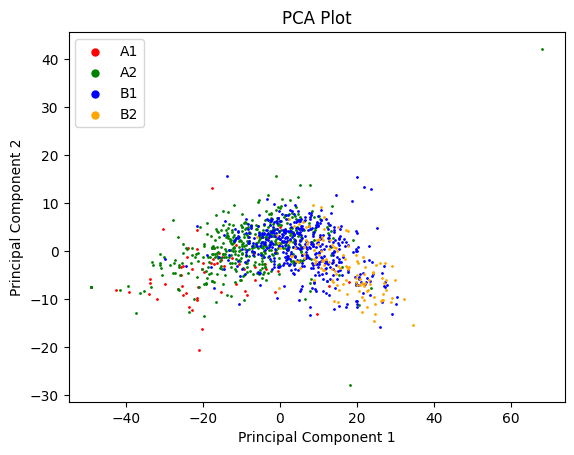

In [3]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Функция для очистки текста от тегов и ненужных слов
def clean_text(text):
    text = re.sub("<.*?>", "", text)  # Удаление тегов
    text = re.sub("unclear", "", text, flags=re.IGNORECASE)  # Удаление слова "unclear"
    return text.strip()

# Функция для приведения слова к лемме
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

def get_lemma(word):
    parsed_word = morph.parse(word)[0]
    lemma = parsed_word.normal_form
    return lemma

# Путь к папке с текстовыми файлами
data_folder = "/content/Students_texts"

# Считывание данных из файла ru_m3.csv и удаление повторяющихся лемм
ru_m3_data = pd.read_csv("ru_m3.csv", delimiter=";")
ru_m3_data = ru_m3_data.drop_duplicates(subset=["Lemma"])

# Создание DataFrame для хранения результатов
columns = ["Filename", "Token Count", "A1 Percentage", "A2 Percentage", "B1 Percentage", "B2 Percentage", "No Match Percentage", "Level"]
results_df = pd.DataFrame(columns=columns)

# Обработка текстовых файлов
for level_folder in os.listdir(data_folder):
    level_path = os.path.join(data_folder, level_folder)
    if os.path.isdir(level_path):
        level = level_folder.upper()
        for filename in os.listdir(level_path):
            file_path = os.path.join(level_path, filename)
            if filename.endswith(".txt") and os.path.isfile(file_path):
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
                    # Очистка текста
                    cleaned_text = clean_text(text)
                    tokens = re.findall(r"\b\w+\b", cleaned_text)  # Разделение на токены

                    # Приведение токенов к леммам
                    lemmas = [get_lemma(token) for token in tokens]
                    unique_lemmas = list(set(lemmas))  # Уникальные леммы

                    # Расчет количества уникальных лемм
                    unique_lemmas_count = len(unique_lemmas)

                    # Сравнение с ru_m3.csv
                    matched_lemmas = ru_m3_data[ru_m3_data["CEFR"].str.upper().isin(["A1", "A2", "B1", "B2"]) & ru_m3_data["Lemma"].str.lower().isin(unique_lemmas)]
                    matched_count = len(matched_lemmas)

                    # Расчет процентов
                    a1_percentage = len(matched_lemmas[matched_lemmas["CEFR"].str.upper() == "A1"]) / unique_lemmas_count * 100
                    a2_percentage = len(matched_lemmas[matched_lemmas["CEFR"].str.upper() == "A2"]) / unique_lemmas_count * 100
                    b1_percentage = len(matched_lemmas[matched_lemmas["CEFR"].str.upper() == "B1"]) / unique_lemmas_count * 100
                    b2_percentage = len(matched_lemmas[matched_lemmas["CEFR"].str.upper() == "B2"]) / unique_lemmas_count * 100
                    no_match_percentage = 100 - (a1_percentage + a2_percentage + b1_percentage + b2_percentage)

                    # Округление процентов до двух десятичных знаков
                    a1_percentage = round(a1_percentage, 2)
                    a2_percentage = round(a2_percentage, 2)
                    b1_percentage = round(b1_percentage, 2)
                    b2_percentage = round(b2_percentage, 2)
                    no_match_percentage = round(no_match_percentage, 2)

                    # Добавление результатов в DataFrame
                    row = [filename, unique_lemmas_count, a1_percentage, a2_percentage, b1_percentage, b2_percentage, no_match_percentage, level]
                    results_df.loc[len(results_df)] = row

# Сохранение результатов в файл students_data.csv
results_df.to_csv("students_data.csv", index=False)

# Вычисление PCA
pca = PCA(n_components=2)
level_labels = results_df["Level"].unique()
level_labels.sort()
level_colors = ["red", "green", "blue", "orange"]
pca_data = pca.fit_transform(results_df[["A1 Percentage", "A2 Percentage", "B1 Percentage", "B2 Percentage"]])

# Построение диаграммы
fig, ax = plt.subplots()
for level_label, level_color in zip(level_labels, level_colors):
    indices = results_df["Level"] == level_label
    ax.scatter(pca_data[indices, 0], pca_data[indices, 1], c=level_color, label=level_label, s=1)  # Изменение размера точек
ax.legend(markerscale=5)  # Увеличение размера маркеров в легенде
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot")
plt.show()